# Melanoma Detection

The problem involves building a Convolutional Neural Network (CNN) model to accurately detect melanoma,
a type of cancer that is responsible for 75% of skin cancer deaths.
Early detection of melanoma is crucial, and a solution that can automatically evaluate skin images and
alert dermatologists about its presence could significantly reduce the manual effort in diagnosis.

The dataset consists of 2,357 images from the International Skin Imaging Collaboration (ISIC) covering a range of malignant and benign skin diseases. The images are classified into several categories, including melanoma, along with other skin conditions such as actinic keratosis, basal cell carcinoma, and more. The dataset is fairly balanced, with a slight dominance of melanoma and moles.

**Goal** is to develop a model that can distinguish melanoma from other skin conditions.

#### Importing Necessary Library

In [51]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Data Reading/Data Understanding**

In [3]:
# Define the path for train and test images

data_dir_train = pathlib.Path("/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [4]:
# print the count of images in test and train

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Train -",image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Test -", image_count_test)

Train - 2239
Test - 118


# **Dataset Creation**

In [5]:
# Load images using keras.preprocessing.image_dataset_from_directory utility.

# Set batch size and image dimensions

batch_size = 32
img_height = 180
img_width = 180

In [6]:
# Load the training dataset with validation split (80% train, 20% validation)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,  # Split data: 80% for training and 20% for validation
    subset="training",  # For training subset
    seed=123,  # For reproducibility
    image_size=(img_height, img_width),  # Resize images
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
# Load the validation dataset (for the remaining 20%)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,  # Split data: 80% for training and 20% for validation
    subset="validation",  # For validation subset
    seed=123,  # For reproducibility
    image_size=(img_height, img_width),  # Resize images
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# Display the shapes of datasets (for verification)

print(f"Training dataset: {train_ds}")
print(f"Validation dataset: {val_ds}")

Training dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Validation dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [9]:
# List out all the classes of skin cancer

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


# **Dataset visualisation**

In [10]:
image_batch, label_batch = next(iter(train_ds))

In [11]:
# Check the shapes of the batch

print(image_batch.shape)
print(label_batch.shape)

(32, 180, 180, 3)
(32,)


The image_batch is a tensor of the shape (32, 180, 180, 3) and the last dimension refers to color channels RGB.
The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

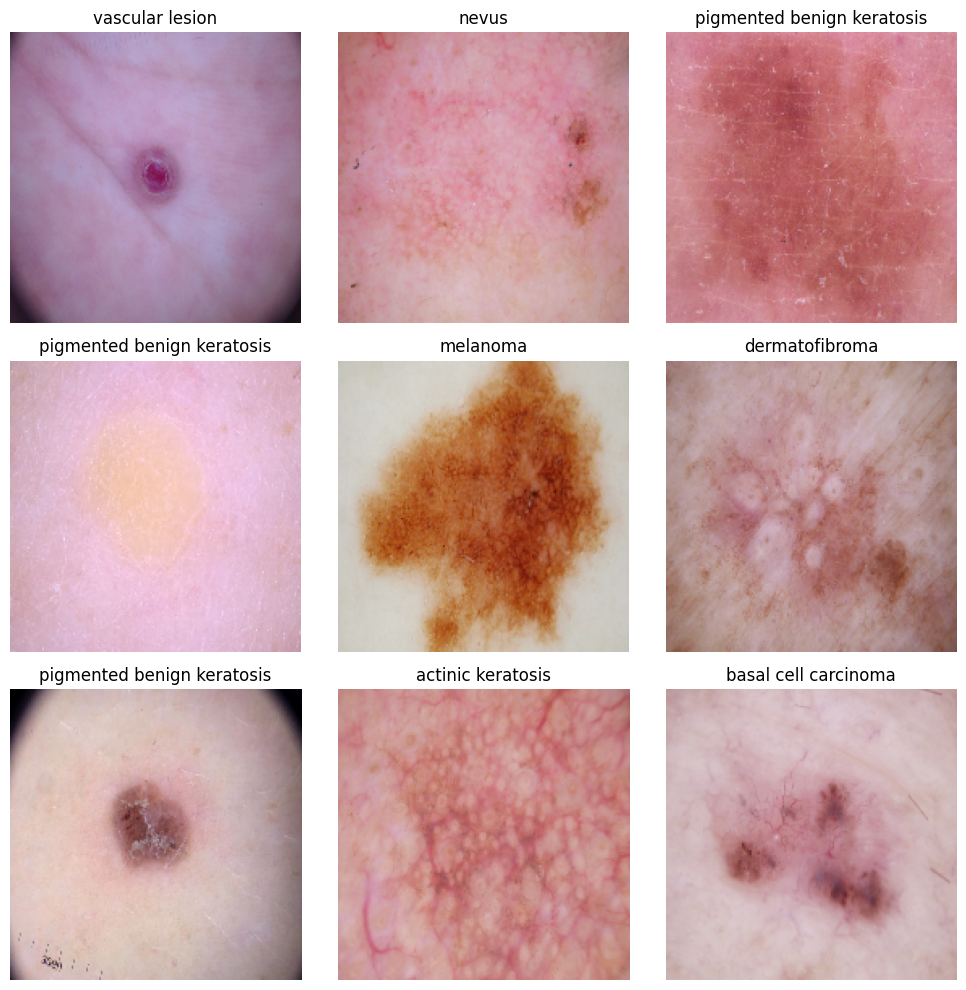

In [12]:
plt.figure(figsize=(10, 10))

# Loop through the classes and display one image for each class
for i in range(len(class_names)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))  # Convert the image from tensor to numpy and show it
    plt.title(class_names[label_batch[i].numpy()])  # Use the label for the title
    plt.axis('off')

plt.tight_layout()
plt.show()

In [13]:
#AUTOTUNE = tf.data.experimental.AUTOTUNE
#train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Common Functions

In [14]:
def plot_training_history(history, epochs, figsize=(12, 8)):
    """
    Plots the training and validation accuracy and loss over epochs.

    """
    epochs_range = range(epochs)

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']


    # Create figure with specified size
    plt.figure(figsize=figsize)

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    # Show the plot
    plt.tight_layout()
    plt.show()

In [78]:
def extract_metrics(history, model_name):
    last_epoch = len(history.history['accuracy'])  # Get the number of epochs
    return pd.DataFrame({
        'Model': model_name,
        'Training Accuracy': history.history['accuracy'][last_epoch - 1],
        'Validation Accuracy': history.history['val_accuracy'][last_epoch - 1],
        'Training Loss': history.history['loss'][last_epoch - 1],
        'Validation Loss': history.history['val_loss'][last_epoch - 1]
    }, index=[0])  # Create a single row DataFrame

# Combine the last epoch metrics from all models
def combine_metrics(histories, model_names):
    df_list = [extract_metrics(histories[i], model_names[i]) for i in range(len(histories))]
    return pd.concat(df_list, ignore_index=True)

# **Model Building & training**

In [17]:
model_baseline = Sequential([
    # Rescale images to [0, 1]
    tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(9, activation='softmax')  # 9 classes
])


In [18]:
model_baseline.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [19]:
# View the summary of all layers
model_baseline.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 176, 176, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 174, 174, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 87, 87, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 968832)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │     496,042,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 496,140,361 (1.85 GB)

 Trainable params: 496,140,361 (1.85 GB)

 Non-trainable params: 0 (0.00 B)

In [20]:
epochs = 20
history_model_1 = model_baseline.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.2316 - loss: 7.6769 - val_accuracy: 0.4519 - val_loss: 1.6447
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 186ms/step - accuracy: 0.4324 - loss: 1.5707 - val_accuracy: 0.3803 - val_loss: 1.6938
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 185ms/step - accuracy: 0.4987 - loss: 1.4912 - val_accuracy: 0.3826 - val_loss: 1.7487
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 187ms/step - accuracy: 0.4944 - loss: 1.4242 - val_accuracy: 0.4631 - val_loss: 1.7453
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 187ms/step - accuracy: 0.6002 - loss: 1.1540 - val_accuracy: 0.4989 - val_loss: 1.9389
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 186ms/step - accuracy: 0.7002 - loss: 0.9092 - val_accuracy: 0.4966 - val_loss: 1.9915
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 186ms/step - accuracy: 0.7601 - loss: 0.7448 - val_accuracy: 0.5145 - val_loss: 2.1143
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 187ms/step - accuracy: 0.8026 - loss: 0.6134 - val_accura

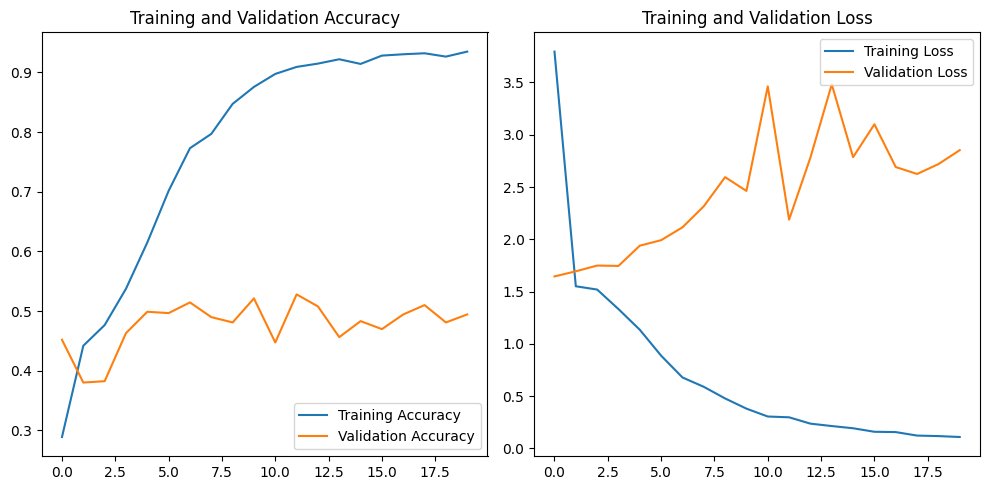

In [21]:
plot_training_history(history_model_1, epochs, figsize=(10, 5))

The baseline model is achieving high accuracy on the training set , but there is a significant drop in performance on the validation set. This discrepancy between training and validation performance indicates overfitting. In overfitting, the model learns to perform well on the training data but fails to generalize to unseen data.

## **Data** **Augmentation**

In [22]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomBrightness(0.2),
    layers.RandomContrast(0.2),
])

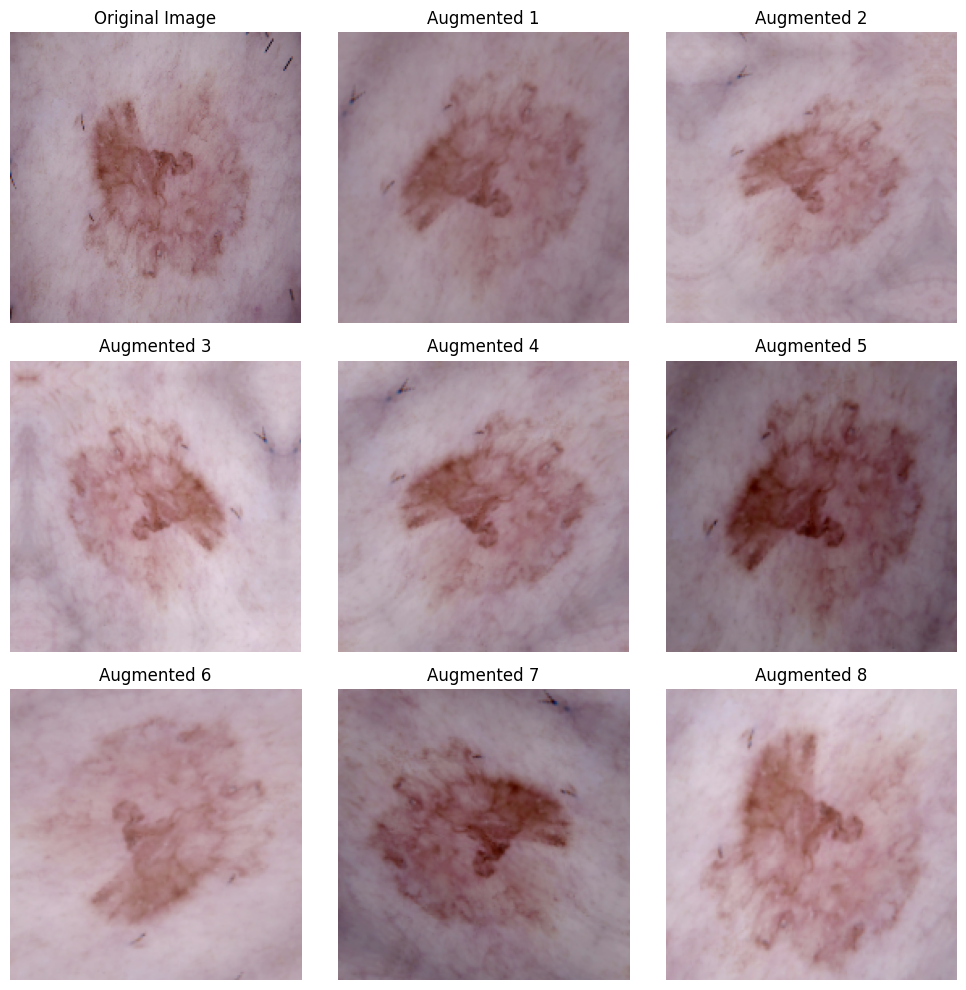

In [23]:
# Visualize original image and its augmented versions

for images, labels in train_ds.take(1):  # Take one batch from the training dataset
    original_image = images[0]

    # Create a new figure to display the images
    plt.figure(figsize=(10, 10))

    # Plot the original image
    plt.subplot(3, 3, 1)
    plt.imshow(original_image.numpy().astype("uint8"))
    plt.title("Original Image")
    plt.axis('off')

    # Apply data augmentation and display the augmented images
    for i in range(2, 10):  # Generate augmented images
        augmented_image = data_augmentation(tf.expand_dims(original_image, 0))  # Apply augmentation
        plt.subplot(3, 3, i)
        plt.imshow(augmented_image[0].numpy().astype("uint8"))
        plt.title(f"Augmented {i-1}")
        plt.axis('off')

    # Show the plot
    plt.tight_layout()
    plt.show()

# **Model Building & training on the augmented data**

In [24]:
model_data_aug = models.Sequential([

    data_augmentation, # data augmentation layer

    layers.Resizing(img_height, img_width),
    layers.Rescaling(1./255),  # Normalize pixel values to [0, 1]

    # First Convolutional Block
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    # Second Convolutional Block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),

    # Third Convolutional Block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    # Flatten layer - to flatten the input to 1D vector
    layers.Flatten(),

    #Dense Layer
    layers.Dense(128, activation='relu'),
    layers.Dense(9, activation='softmax')  # Output layer for 9 classes
])

In [25]:
# Compile the model
model_data_aug.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [26]:
# View the summary of all layers
model_data_aug.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)            │ (1, 180, 180, 3)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resizing (Resizing)                  │ (1, 180, 180, 3)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ (1, 180, 180, 3)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (1, 178, 178, 32)           │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (1, 89, 89, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (1, 87, 87, 64)             │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (1, 43, 43, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (1, 43, 43, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (1, 41, 41, 128)            │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (1, 20, 20, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (1, 51200)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (1, 128)                    │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (1, 9)                      │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Train the model
epochs = 20

history_model_2 = model_data_aug.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)


Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.2293 - loss: 2.3694 - val_accuracy: 0.3512 - val_loss: 1.8484
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.3621 - loss: 1.7582 - val_accuracy: 0.3781 - val_loss: 1.7241
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.3955 - loss: 1.6852 - val_accuracy: 0.4183 - val_loss: 1.6700
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.4544 - loss: 1.5392 - val_accuracy: 0.4653 - val_loss: 1.5589
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.4696 - loss: 1.5294 - val_accuracy: 0.4698 - val_loss: 1.5008
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.4701 - loss: 1.5307 - val_accuracy: 0.4161 - val_loss: 1.6540
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.4212 - loss: 1.5646 - val_accuracy: 0.5034 - val_loss: 1.4173
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.5050 - loss: 1.4115 - val_accuracy: 0.4340 - v

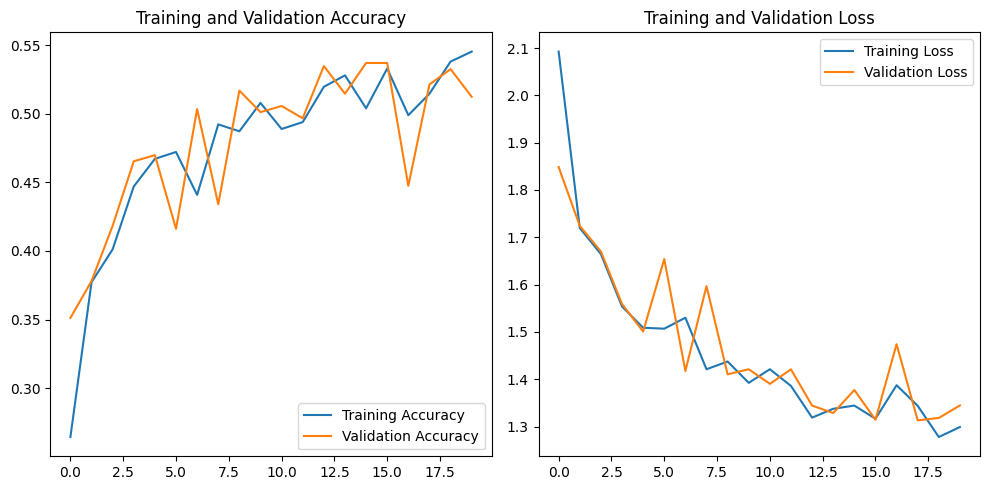

In [28]:
plot_training_history(history_model_2, epochs, figsize=(10, 5))

### Findings

**Loss values are somewhat high, indicating that the model has not yet fully learned the underlying patterns in the data and might still be underfitting.**

We can improve the model by
1. Increasing the epochs
2. Checking the class imbalance
3. Adding the dropout layers and batch normalisation

Class Imbalance can have a detrimental effect on the final model quality.
If some classes dominate the training set, the model might become biased toward those classes and not learn well for others.

# **Class Distribution**

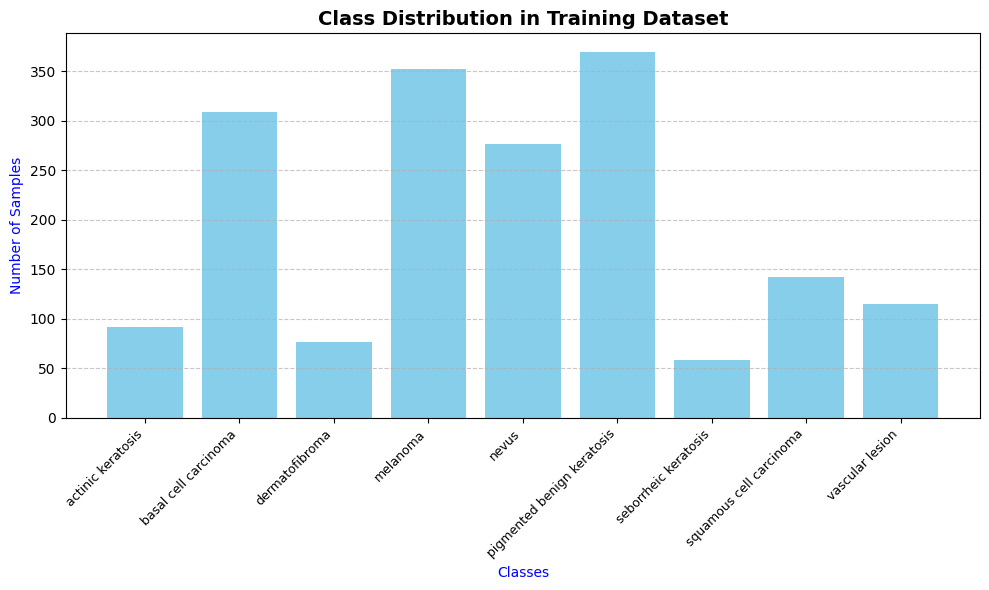

In [33]:
# Count the number of samples per class by iterating through the dataset
class_counts = {class_name: 0 for class_name in class_names}

# Iterate through the dataset and count samples per class
for images, labels in train_ds:
    for label in labels.numpy():
        class_counts[class_names[label]] += 1

# Plot the class distribution
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')

# Enhance font size and style
plt.title('Class Distribution in Training Dataset', fontsize=14, fontweight='bold')
plt.xlabel('Classes', fontsize=10,color='blue')
plt.ylabel('Number of Samples', fontsize=10,color='blue')

# Add gridlines for clarity
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=9)

# Display the plot
plt.tight_layout()
plt.show()

In [34]:
# Create a DataFrame to show class distribution

class_distribution = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Number of Samples'])
class_distribution.sort_values(by='Number of Samples')

,Class,Number of Samples
6,seborrheic keratosis,58
2,dermatofibroma,77
0,actinic keratosis,92
8,vascular lesion,115
7,squamous cell carcinoma,142
4,nevus,277
1,basal cell carcinoma,309
3,melanoma,352
5,pigmented benign keratosis,370


**Class with the Least Samples:**

Seborrheic keratosis (Class 6) has the least samples, with 58 samples.

**Dominating Classes:**

pigmented benign keratosis class (Class 5) dominates with 370 samples,
followed by
*   Melanoma (Class 3): 352 samples
*   Basal cell carcinoma (Class 1): 309 samples


# **Handling class imbalances**

In [37]:
import Augmentor

# Loop through each class and apply augmentation
for class_name in class_names:
    class_path = os.path.join(data_dir_train, class_name)  # Full path to the class directory
    if os.path.isdir(class_path):  # Check if the path is a directory
        p = Augmentor.Pipeline(class_path)  # Create a pipeline for the class
        p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)  # Rotate images
        p.sample(500)  # Sample 500 augmented images per class


Initialised with 114 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7D6D14179F00>: 100%|██████████| 500/500 [00:05<00:00, 95.89 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7D6D14198790>: 100%|██████████| 500/500 [00:04<00:00, 108.09 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D6D141B3640>: 100%|██████████| 500/500 [00:04<00:00, 107.88 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7D6D141F0E50>: 100%|██████████| 500/500 [00:13<00:00, 36.37 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7D6DE0161240>: 100%|██████████| 500/500 [00:15<00:00, 33.13 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7D6D150DDAB0>: 100%|██████████| 500/500 [00:04<00:00, 106.74 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7D6DFB669570>: 100%|██████████| 500/500 [00:07<00:00, 70.73 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D6DC3F62E30>: 100%|██████████| 500/500 [00:04<00:00, 110.44 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D6D14178130>: 100%|██████████| 500/500 [00:04<00:00, 104.57 Samples/s]


In [38]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


#### Lets see the distribution of augmented data after adding new images to the original training data.

In [40]:
from glob import glob

# Create original_df from the original images
original_path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
original_labels = [os.path.basename(os.path.dirname(y)) for y in original_path_list]

# Create a DataFrame for the original dataset
original_df = pd.DataFrame({'Path': original_path_list, 'Label': original_labels})
original_counts = original_df['Label'].value_counts()
# Get the list of augmented image paths
augmented_path_list = [x for x in glob(os.path.join(data_dir_train, '*', 'output', '*.jpg'))]

# Extract the labels (lesion types) from the augmented paths
augmented_labels = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in augmented_path_list]

# Create a DataFrame for the augmented dataset
augmented_df = pd.DataFrame({'Path': augmented_path_list, 'Label': augmented_labels})

# Combine original and augmented DataFrames
new_df = pd.concat([original_df, augmented_df], ignore_index=True)  # Use ignore_index=True to reset the index

# Count the number of images for each label
new_counts = new_df['Label'].value_counts()


In [41]:
# Merge the counts into a single dataframe
count_df = pd.merge(original_counts, new_counts, on='Label', how='outer')
count_df.columns = ['Original Cnt', 'New Cnt']
count_df.reset_index()


,Label,Original Cnt,New Cnt
0,actinic keratosis,114,614
1,basal cell carcinoma,376,876
2,dermatofibroma,95,595
3,melanoma,438,938
4,nevus,357,857
5,pigmented benign keratosis,462,962
6,seborrheic keratosis,77,577
7,squamous cell carcinoma,181,681
8,vascular lesion,139,639


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

# **Model Building & training on the rectified class imbalance data**

In [43]:
batch_size = 32
img_height = 180
img_width = 180

In [44]:
train_ds_aug = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,  # Split data: 80% for training and 20% for validation
    subset="training",  # For training subset
    seed=123,  # For reproducibility
    image_size=(img_height, img_width),  # Resize images
    batch_size=batch_size
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [45]:
val_ds_aug = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,  # Split data: 80% for training and 20% for validation
    subset="validation",  # For validation subset
    seed=123,  # For reproducibility
    image_size=(img_height, img_width),  # Resize images
    batch_size=batch_size
)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [63]:
from tensorflow.keras.optimizers import Adam

# Define the model
model_Augmentor = Sequential([

    layers.Rescaling(1./255, input_shape=(180, 180, 3)),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.4),  # Dropout after pooling layer

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),  # Batch normalization after Conv2D
    Dropout(0.4),  # Dropout after pooling layer

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    # BatchNormalization(),
    Dropout(0.4),

    Conv2D(64, (3, 3), activation='relu'),
    Dropout(0.6),

    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.6),
    Dense(9, activation='softmax')
])

model_Augmentor.summary()


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_8 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 89, 89, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 87, 87, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 43, 43, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 43, 43, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 43, 43, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 41, 41, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 18, 18, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 18, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 20736)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 1024)                │      21,234,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 9)                   │           9,225 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,309,737 (81.29 MB)

 Trainable params: 21,309,609 (81.29 MB)

 Non-trainable params: 128 (512.00 B)

In [65]:
optimizer = Adam(learning_rate=0.001)
model_Augmentor.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [66]:
# Training
epochs = 50

from tensorflow.keras.callbacks import ReduceLROnPlateau

#The learning rate is reduced by a factor after a specific numbers of epochs.
# For example, you might start with a learning rate of 0.1 and reduce it by a factor
# of 0.5 every 10 epochs. This method is simple yet effective, allowing for
# initial rapid learning that slows down over time.
learning_rate_reduction_AG = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.0001)
history_model_3 = model_Augmentor.fit(
    train_ds_aug,
    validation_data=val_ds_aug,
    epochs=epochs,
    callbacks=[learning_rate_reduction_AG])


Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 22s 95ms/step - accuracy: 0.1619 - loss: 3.2979 - val_accuracy: 0.1151 - val_loss: 2.2256 - learning_rate: 0.0010
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.2521 - loss: 1.9278 - val_accuracy: 0.1151 - val_loss: 2.3705 - learning_rate: 0.0010
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.2740 - loss: 1.8502 - val_accuracy: 0.1151 - val_loss: 2.4694 - learning_rate: 0.0010
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - accuracy: 0.2977 - loss: 1.8062 - val_accuracy: 0.2079 - val_loss: 2.0367 - learning_rate: 0.0010
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - accuracy: 0.3079 - loss: 1.7405 - val_accuracy: 0.1789 - val_loss: 2.1451 - learning_rate: 0.0010
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - accuracy: 0.3375 - loss: 1.6811 - val_accuracy: 0.1559 - val_loss: 2.1220 - learning_rate: 0.0010
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - accuracy: 0.3045 - l

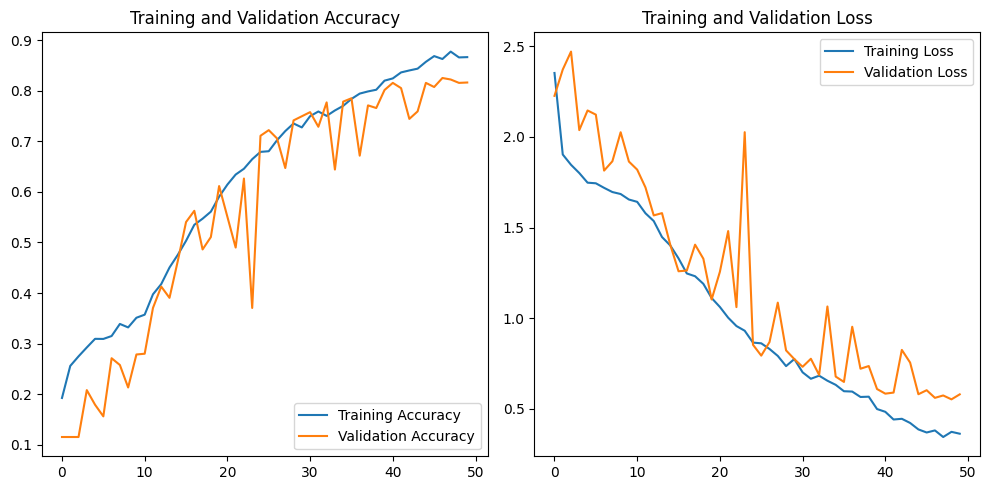

In [67]:
plot_training_history(history_model_3, epochs, figsize=(10, 5))

### **Findings**

After using the Augmentor library to address the class imbalance in the dataset, the following results were achieved:

After 50 epochs of training, the model reached an
*   Training accuracy of 87.04% with a loss of 0.3592.
*   Validation accuracy improved significantly, reaching 81.66%, with a corresponding validation loss of 0.5806.

**Data Augmentation helped the model to perform better by addressing the class imbalance in the dataset.**




## **Overall Metrics**

In [79]:
histories = [history_model_1, history_model_2, history_model_3]
model_names = ['BaseLine Model', 'Dynamic Data Augmentation Model ', 'Data AugmentorLib Model']

# Combine the metrics
combined_metrics = combine_metrics(histories, model_names)

In [77]:
combined_metrics

,Model,Training Accuracy,Validation Accuracy,Training Loss,Validation Loss
0,BaseLine Model,0.934710,0.494407,0.108837,2.852725
1,Dynamic Data Augmentation Model,0.545201,0.512304,1.298980,1.344602
2,Data AugmentorLib Model,0.866840,0.816630,0.363754,0.580637
